# 환경설정

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("현재 디바이스: {}".format(device))

torch.manual_seed(42) # 재현성을 위한 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42) # gpu 쓸 땐 모든 seed 고정

현재 디바이스: cuda


In [16]:
drive.mount('/content/drive')
dir_path = '/content/drive/MyDrive/DDFS/'
data_path = './celeba'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터셋

In [4]:
# 효율을 위해 드라이브에서 사진 불러오지 않고
# 직접 ./content에 압축해제함
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/DDFS/data/celeba.zip'
extract_dir = './celeba'

os.makedirs(extract_dir, exist_ok=True)

if os.path.exists(zip_file_path):
    print(f"'{zip_file_path}'의 압축을 '{extract_dir}'에 해제합니다...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"'{zip_file_path}' 파일의 압축이 '{extract_dir}'에 성공적으로 해제되었습니다.")
else:
    print(f"오류: 압축 파일 '{zip_file_path}'을(를) 찾을 수 없습니다.")

'/content/drive/MyDrive/DDFS/data/archive.zip'의 압축을 './celeba'에 해제합니다...
'/content/drive/MyDrive/DDFS/data/archive.zip' 파일의 압축이 './celeba'에 성공적으로 해제되었습니다.


In [5]:
class CelebADataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_dir = img_dir
    self.transform = transform
    self.img_names = os.listdir(img_dir)
  def __len__(self):
    return len(self.img_names)
  def __getitem__(self, idx):
    img_name = os.path.join(self.img_dir, self.img_names[idx])
    image = Image.open(img_name).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [17]:
image_data_path = os.path.join(data_path, '50k') # Update data_path to point to the actual image directory
celeba_data = CelebADataset(img_dir=image_data_path, transform=transform)
data_loader = DataLoader(dataset = celeba_data, batch_size = 64, shuffle = True, num_workers=os.cpu_count(), pin_memory=True)

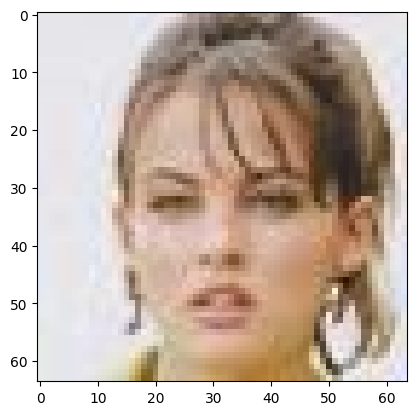

In [18]:
plt.imshow(celeba_data[0].permute(1, 2, 0))

# VAE 모델 정의

In [19]:
class VAE(nn.Module):
  def __init__(self, input_channels, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1), # Changed stride from 4 to 2
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    )

    self.fc1 = nn.Linear(256*4*4, latent_dim) # mean
    self.fc2 = nn.Linear(256*4*4, latent_dim) # variance
    self.fc3 = nn.Linear(latent_dim, 256*4*4) # latent

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size= 4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )

  def encode(self, x):
    h = self.encoder(x)
    h = h.view(h.size(0), -1)
    return self.fc1(h), self.fc2(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar) # standard variation
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, z):
    h = self.fc3(z)
    h = h.view(h.size(0), 256, 4, 4)
    return self.decoder(h)

  # 순전파 함수
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [20]:
def loss_function_MSE(recon_x, x, mu, logvar):
  MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return MSE + KLD

In [21]:
def show_images(images):
  fig, axes = plt.subplots(1, len(images), figsize=(len(images*2), 2))
  for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.show

In [22]:
def interpolate_letent_space(model, start, end, steps=10):
  vectors = [] # start, end 사이의 10개의 벡터로 점진적 이미지 생성
  alpha_values = np.linspace(0, 1, steps)
  for alpha in alpha_values:
    vec = start*(1-alpha) + end*alpha
    vectors.append(vec)
  vectors = torch.stack(vectors)
  return vectors

In [23]:
model = VAE(input_channels=3, hidden_dim=400, latent_dim=100).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습

In [24]:
from tqdm.auto import tqdm

def train(epoch, loss_func):
  model.train()
  train_loss = 0
  # Wrap data_loader with tqdm for a progress bar
  for batch_idx, data in enumerate(tqdm(data_loader, desc=f'Epoch {epoch}')):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_func(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print(f'Epoch {epoch}, Loss: {train_loss/len(data_loader.dataset)}')


In [29]:
loss_func = loss_function_MSE
for epoch in range(1, 11):
  train(epoch, loss_func)

Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1, Loss: 182.97242568847656


Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2, Loss: 182.34766649902343


Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3, Loss: 181.7537402294922


Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4, Loss: 181.14124405273438


Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5, Loss: 180.53267641601562


Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6, Loss: 180.33768126953126


Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7, Loss: 179.8170961328125


Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8, Loss: 179.5705437988281


Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9, Loss: 179.234715546875


Epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10, Loss: 178.64722100585936


## 모델 저장

In [31]:
model_save_dir = os.path.join(dir_path, 'model')
os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, 'vae_model.pkl')
torch.save(model.state_dict(), model_save_path)

print(f"모델이 '{model_save_path}'에 성공적으로 저장되었습니다.")

모델이 '/content/drive/MyDrive/DDFS/model/vae_model.pkl'에 성공적으로 저장되었습니다.


# 이미지 생성

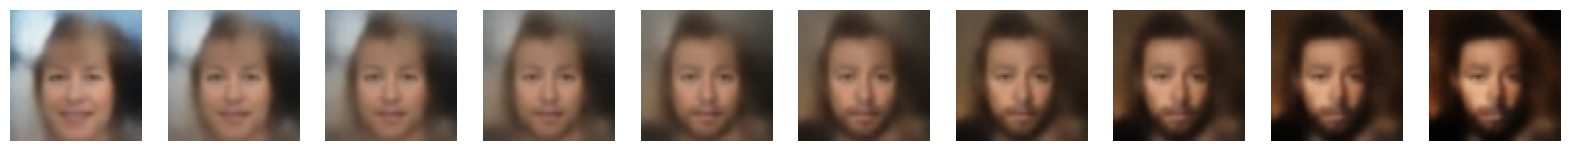

In [30]:
steps = 10
with torch.no_grad():
  z_start = torch.randn(1, 100).to(device)
  z_end = torch.randn(1, 100).to(device)
  interpolate_z = interpolate_letent_space(model, z_start, z_end)
  samples = model.decode(interpolate_z).cpu()
  # Permute the dimensions of each sample for correct display by matplotlib
  show_images([samples[i].permute(1, 2, 0) for i in range(steps)])
  torch.cuda.empty_cache()